# Spacecraft component segmentation

Semantic segmentation of spacecraft components based on the [Spacecraft Dataset for Detection, Segmentation, and Parts Recognition](https://github.com/Yurushia1998/SatelliteDataset) [(arXiv:2106.08186)](https://arxiv.org/abs/2106.08186). The DeepLabV3 model with the MobileNetV3 backbone is used. This is the [Kaggle vesrion of the notebook](https://www.kaggle.com/code/dkudryavtsev/spacecraft-component-segmentation).

In [ ]:
#########1#########2#########3#########4#########5#########6#########7#########

import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from tqdm import tqdm
from kaggle_secrets import UserSecretsClient  # for Wandb logging

# https://www.kaggle.com/datasets/dkudryavtsev/spacecrafts
# (add to the notebook data on Kaggle)
DATA = Path(
    '/kaggle/input/spacecrafts/Spacecrafts')
WORKING = Path(
    '/kaggle/working')
# the output of the previous notebook run with the saved weights (spacecraft.pt)
# (optional: add to data after the first launch, if needed)
SAVED_RESULTS = Path(
    '/kaggle/input/spacecraft-component-segmentation')
BATCH_SIZE = 32

### Dataset contents

In [2]:
!ls {DATA}/*.txt
!tree -d {DATA}

/kaggle/input/spacecrafts/Spacecrafts/ReadMe.txt
/kaggle/input/spacecrafts/Spacecrafts/all_bbox.txt
/kaggle/input/spacecrafts/Spacecrafts
├── images
│   ├── train
│   └── val
└── mask
    ├── train
    └── val

6 directories


### Custom PyTorch Dataset

The original RGB masks are one-hot encoded to tensors of the \[C, H, W\] dimensions with four (C=4) channels: one background and three classes. Some images in the dataset are corrupted and cannot be read, also there are no masks for a number of images, therefore for these cases we skip to the next images using a try/except construction.

In [3]:
class SpacecraftDataset(Dataset):
    def __init__(self, transforms, split='train'):
        if split == 'train':
            self.image_path = DATA/'images/train'
            self.mask_path = DATA/'mask/train'
        else:
            self.image_path = DATA/'images/val'
            self.mask_path = DATA/'mask/val'
                            
        self.image_filenames = sorted(self.image_path.glob('*.png'))       
        self.transform = transforms


    def __len__(self):
        return len(self.image_filenames)

    
    def __getitem__(self, idx):
        """ Try/except is to skip to the next index for corrupted images
            or when a mask is absent
        """
        try: 
            # Reading in an image
            image_filename = self.image_filenames[idx]   
            image = cv2.imread(str(image_filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                   
            # Reading in a mask
            mask_filename = (
                self.mask_path/
                    str(image_filename.name.split('.')[0] + '_mask.png'))
            if mask_filename.is_file():
                mask = cv2.imread(str(mask_filename))
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            else:
                raise(IOError)
            
            # Mask one-hot encoding: background + 3 classes
            mask[mask!=0] = 1
            foreground = np.ubyte(np.sum(mask, axis=2))
            background = foreground^1
            background = background[:, :, np.newaxis]
            mask = (np.concatenate((background, mask), axis=2)
                    .astype(np.float32))
                                    
            # Transformations/augmentations
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
            mask = mask.permute(2, 0, 1)  # (H,W,C) -> (C,H,W)
            return image, mask.to(torch.float32)
            
        except:
            # skip to the next index
            if idx + 1 <= self.__len__():
                return self.__getitem__(idx + 1)
            else:
                raise StopIteration

### Augmentations and transformations

Augmentation of the training dataset. We also resize the images to $520\times520$ px and normalize them with the default mean and std values, according to the [recommendations](https://pytorch.org/vision/main/models/generated/torchvision.models.segmentation.deeplabv3_mobilenet_v3_large.html#torchvision.models.segmentation.deeplabv3_mobilenet_v3_large) for the PyTorch implementation of the DeepLabV3 model which is to be used further.

In [4]:
train_transforms = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomCropFromBorders(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25),
        A.AdvancedBlur(),
        A.RandomBrightnessContrast(brightness_limit=[-0.3, 0.1])
    ]),
    A.Resize(520, 520),
    A.RandomRotate90(),
    A.Normalize(),
    ToTensorV2()
    ])

valid_transforms = A.Compose([
    A.Resize(520, 520),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = SpacecraftDataset(transforms=train_transforms)
valid_dataset = SpacecraftDataset(transforms=valid_transforms, split='val')

## Checking if everuthing is OK with dataset readout:
#for el in tqdm(train_dataset):
#    pass
#for el in tqdm(valid_dataset):
#    pass

### Visualization of images, augmentations, and masks

Here are the functions that randomly display our images (augmented for the training dataset and original for the validation). Notice that the images both feeded to the network and the inference are actually of the 520x520 size, but for visualization we restore their original format. The function "predict_mask" returns the predicted mask calculated from the output logits of the network.

In [5]:
def normim_to_numpy(image, mask, size=(720, 1280)):
    """Converts a normalized torch.Tensor image
       to a "H,W,C" array of integers [0-255]
       Restores the original image size (1280x720)
    """
    transform = A.Compose([
        A.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225 ], 
                    max_pixel_value=1.),
        A.Normalize(mean=[-0.485, -0.456, -0.406], std=[ 1., 1., 1. ], 
                    max_pixel_value=1.),
        A.Resize(*size)
    ])
                
    image = image.numpy().transpose((1, 2, 0))
    mask = mask[1:,:,:].numpy().transpose((1, 2, 0))
    transformed = transform(image=image, mask=mask)
    image = transformed['image']
    mask = transformed['mask']
    image = (image * 255).astype(np.uint8)
    
    return np.ascontiguousarray(image), np.ascontiguousarray(mask)


def predict_mask(model, image):
    """Predicting a mask
    """
    model.eval()
    model.to('cpu')
    
    # predict logits [C, H, W]
    with torch.no_grad(): 
        pred_mask = model(image.unsqueeze(0))['out'].squeeze(0)    
        
    # class for each pixel [H, W]
    pred_mask = pred_mask.argmax(dim=0)  
       
    # one-hot [H, W, C] 
    pred_mask = torch.eye(4)[pred_mask.to(torch.int64)]  
      
    # background removed [H, W, 3 channels] == RGB image
    pred_mask = pred_mask[:,:,1:].numpy()
    
    transform = A.Resize(720, 1280)              
    image = image.numpy().transpose((1, 2, 0))
    pred_mask = transform(image=image, mask=pred_mask)['mask']
    
    return pred_mask


def display_random_examples(dataset, n=2, model=None):
    if model is None:
        fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 3*n))
    else:
        fig, ax = plt.subplots(nrows=n, ncols=3, figsize=(15, 3*n))
                
    for i in range(n):
        im_tensor, mask_tensor = dataset.__getitem__(np.random.randint(len(dataset)))
        image, mask = normim_to_numpy(im_tensor, mask_tensor)
                                
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(image)
        ax[i, 1].imshow(mask, alpha=0.5)
          
        ax[i, 0].set_title('Image')
        ax[i, 1].set_title('Mask')
                 
        if model is not None:
            ax[i, 2].imshow(image)
            ax[i, 2].imshow(
                predict_mask(model, im_tensor), alpha=0.5)
            ax[i, 2].set_title('Predicted mask')
    
    [axi.set_axis_off() for axi in ax.ravel()]
    plt.tight_layout()
    plt.show()

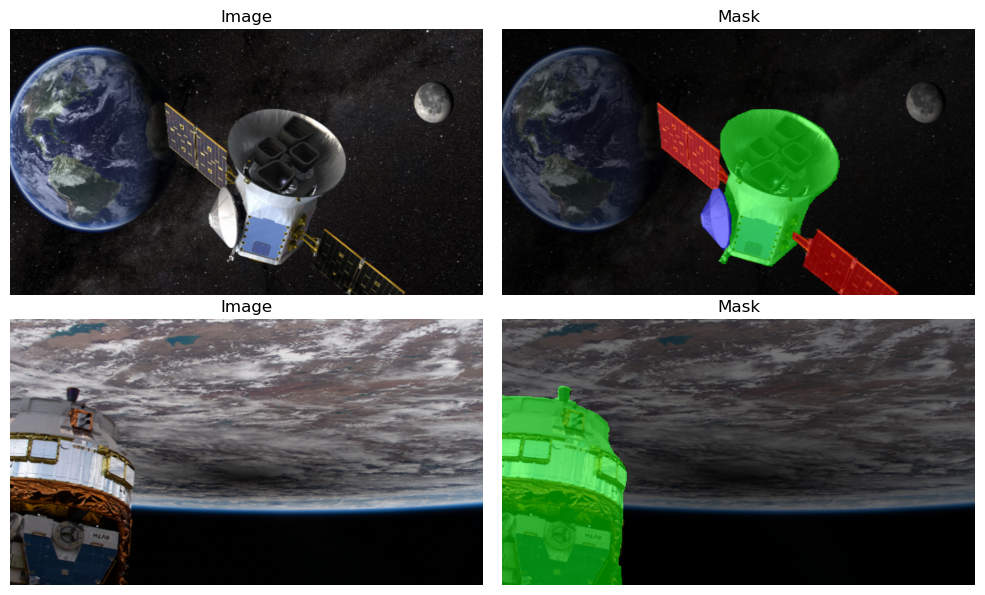

In [30]:
display_random_examples(train_dataset)

### The intersection-over-union metric for our case

In [7]:
def IoU(preds, targs, device='cuda', eps: float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Rewritten from https://github.com/kevinzakka/pytorch-goodies
        for one-hot-encoded masks (targs) 
    
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, C, H, W]. C==0 is the background class
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value
             for multi-class image segmentation
    """
    
    # Take softmax along class dimension; 
    # all class probs add to 1 (per pixel)
    probas = F.softmax(preds, dim=1)

    targs = targs.type(preds.type()).to(device)

    # Sum probabilities by class and across batch images 
    # Background class (dims==1) is excluded (dims==0 is for batch)
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * targs, dims)  # [class0,class1,...]
    cardinality = torch.sum(probas + targs, dims)  # [class0,class1,...]
    union = cardinality - intersection
    iou = (intersection / (union+eps)).mean()  # find mean class IoU values
    return iou

### Custom [PyTorch Lighnting module](https://pytorch-lightning.readthedocs.io/en/2.0.5/common/lightning_module.html)

We use the cross entropy loss function and evaluate the results with the intersection over union metric. 

The optimizer is Adamax (Adam with the infinity norm). We also set the initial learning rate at the beginning of the epochs to vary according to the "cosine annealing with warm restarts" schedule (see the figure). This procedure results in better metrics according to several experiments performed (not reflected here): it seems like the initial learning rate influences the performance of the Adam optimizer, and one can never know what the rate is the best. These variations help to get the optimal initial learning rate at least for some epochs, which helps achive better and more stable convergence.

<img src='figs/lr_schedule.png' height='300'/>

In [8]:
class SegModel(pl.LightningModule):
    def __init__(self, model, batch_size, lr, train_dataset, valid_dataset):
        super(SegModel, self).__init__()
        self.net = model
        self.batch_size = batch_size
        self.learning_rate = lr
        self.trainset = train_dataset
        self.valset = valid_dataset
        self.criterion =torch.nn.CrossEntropyLoss()
        

    def forward(self, x):
        return self.net(x)


    def training_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)['out'] # [B, C, H, W]
        loss_val = self.criterion(out, mask.float())
        iou_score = IoU(out, mask)
        self.log('train_loss', loss_val, prog_bar=True)
        self.log('train_iou', iou_score, prog_bar=True)
        return loss_val


    def configure_optimizers(self):
        opt = torch.optim.Adamax(self.net.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10)
        return [opt], [sch]


    def train_dataloader(self):
        return DataLoader(self.trainset, 
                          drop_last=True,  # drop last incomplete batch
                          batch_size=self.batch_size, 
                          shuffle=True, num_workers=os.cpu_count())

    
    def val_dataloader(self):
        return DataLoader(self.valset, 
                          drop_last=True,  # drop last incomplete batch
                          batch_size=self.batch_size, 
                          shuffle=False, num_workers=os.cpu_count())

    
    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)['out']
        loss_val = self.criterion(out, mask.float())
        iou_score = IoU(out, mask)
        self.log('val_loss', loss_val, prog_bar=True)
        self.log('val_iou', iou_score, prog_bar=True)

### DeepLabV3 model

We use the PyTorch implementation of the [DeepLabV3 model with the MobileNetV3 backbone](https://pytorch.org/vision/main/models/generated/torchvision.models.segmentation.deeplabv3_mobilenet_v3_large.html#torchvision.models.segmentation.deeplabv3_mobilenet_v3_large) (11 mln parameters, 10.45 GFLOPS). Although the dataset is quite different from COCO, which the model has been trained with, the use of the pretrained weights is beneficial. We change the output layers of the classifiers to fit our 3 classes+background and make all the parameters to be trainable.

In [9]:
model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(
    weights='DEFAULT')
model.classifier[4] = nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(10, 4, kernel_size=(1, 1), stride=(1, 1))
for params in model.parameters():
    params.requires_grad = True
    
all_params = sum(p.numel() for p in model.parameters())
train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'No of parameters: {all_params}')
print(f'No of trainable parameters: {train_params}')

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 217MB/s]

No of parameters: 11024772
No of trainable parameters: 11024772


### Model training

Training of the model. Additionally, here we estimate the initial learning rate and maximum batch size using the PyTorch Lightning Tuner (this affects only the very first estimation of the learning rate and does not interfere with the scheduler or Adam algorithms).

The Wandb logging service has been used, the charts can be seen on https://wandb.ai/masterbias/Spacecrafts/runs/m0wmpczf, the figure for IoU on the validation dataset is also provided below.

In [ ]:
# Authorizing on the Wandb logging service
# Tutorial for Kaggle:
# https://www.kaggle.com/code/samuelcortinhas/weights-biases-tutorial-beginner
user_secrets = UserSecretsClient()
key = user_secrets.get_secret('wandb_api_key') 
wandb.login(key=key)
wandb_logger = WandbLogger(project='Spacecrafts')

# The model 
pl_model = SegModel(model, BATCH_SIZE, 0.02, train_dataset, valid_dataset)
checkpoint_callback = ModelCheckpoint(
    save_weights_only=True, monitor='val_iou', mode='max')

# Pytorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=500,
    logger=wandb_logger,
    log_every_n_steps=10,
    callbacks=[
        checkpoint_callback,
        LearningRateMonitor('epoch'),
        EarlyStopping(monitor='val_iou', mode='max', patience=15),
    ],  
)

# Batch size and initial learning rate estimation
tuner = pl.tuner.Tuner(trainer)
tuner.scale_batch_size(pl_model)
tuner.lr_find(pl_model)

# Model training
trainer.fit(pl_model)

# Saving the weights
torch.save(pl_model.state_dict(), WORKING/'spacecrafts.pt')

wandb.finish()

<img src='figs/val_iou.png' height='300'/>

### Validation

In case the kernel was stopped and the previously saved results need to be loaded:

In [10]:
#model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(
#    weights='DEFAULT')
#model.classifier[4] = nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
#model.aux_classifier[4] = nn.Conv2d(10, 4, kernel_size=(1, 1), stride=(1, 1))
#
#pl_model = SegModel(model, BATCH_SIZE, 0.02, train_dataset, valid_dataset)
#pl_model.load_state_dict(torch.load(SAVED_RESULTS/'spacecrafts.pt'))
#
#trainer = pl.Trainer()

In [11]:
trainer.validate(pl_model, 
                 dataloaders=pl_model.val_dataloader())

Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_iou          │    0.7533696889877319     │
│         val_loss          │    0.10044980049133301    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.10044980049133301, 'val_iou': 0.7533696889877319}]

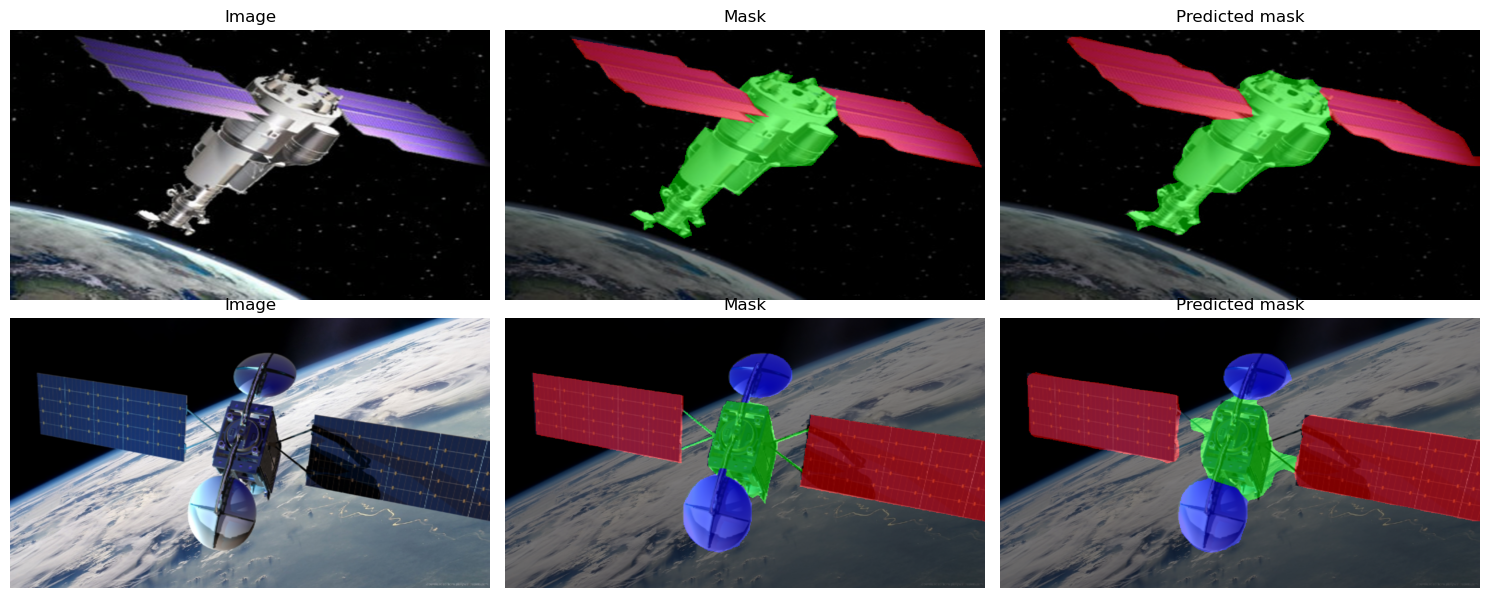

In [25]:
display_random_examples(valid_dataset, 2, pl_model)

### Conclusion

A model for semantic segmentation of spacecraft components (body, solar panels, antennas) has been constructed based on the pretrained DeepLabV3 network. An IOU metric of 0.75 has been achieved.